<a href="https://colab.research.google.com/github/ankitstar01/ml_test/blob/master/Stock_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras
import os
 
from sklearn.preprocessing import MinMaxScaler
from textblob import TextBlob
from polygon import RESTClient
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, Activation
 
API_KEY = 'vqeohd8x5k1x6PKiisJQS8RgS3A1iRQC'
ticker = 'NIO'

In [ ]:
def get_all_data(ticker, api_key):
    f = open('ticker_folder/' + ticker + '.csv', 'w')
    with RESTClient(api_key) as client:
        resp = client.stocks_equities_aggregates(ticker=ticker, multiplier=1, timespan='minute',
                                                 from_='2021-01-20', to='2021-02-04', unadjusted=False,
                                                 sort='asc', limit=50000)
        resp = resp.results
        f.write('timestamp,open,low,high,volume,close\n')
        for query in resp:
            f.write(str(query['t']) + ',' + str(query['o']) + ',' + str(query['l']) + ','
                    + str(query['h']) + ',' + str(query['v']) + ',' + str(query['c']) + '\n')
    f.close()
    f = open('ticker_folder/' + ticker + '.csv', 'r')
    df = pd.read_csv(f)
    return df

In [ ]:
df = get_all_data(ticker, API_KEY)
df.tail()

,timestamp,open,low,high,volume,close
10970,1612486500000,57.64,57.60,57.64,9566.0,57.64
10971,1612486560000,57.63,57.62,57.63,713.0,57.62
10972,1612486620000,57.61,57.61,57.62,1086.0,57.61
10973,1612486680000,57.62,57.62,57.63,3045.0,57.62
10974,1612486740000,57.62,57.60,57.63,4660.0,57.60


In [ ]:
df = df.drop(['timestamp'], axis=1)
df.tail()

,open,low,high,volume,close
10970,57.64,57.60,57.64,9566.0,57.64
10971,57.63,57.62,57.63,713.0,57.62
10972,57.61,57.61,57.62,1086.0,57.61
10973,57.62,57.62,57.63,3045.0,57.62
10974,57.62,57.60,57.63,4660.0,57.60


In [ ]:
def split_data(data):
    rows = len(data)
    data_training = data[:rows - 30]
    data_testing = data[rows - 30:]

    scaler = MinMaxScaler()
    training_data = data_training.copy()
    data_training = scaler.fit_transform(data_training)

    x_train, y_train = [], []
    x_test, y_test = [], []

    for i in range(30, data_training.shape[0]):
        x_train.append(data_training[i - 30: i])
        y_train.append(data_training[i, 0])
    
    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)

    past_30 = training_data.tail(30)
    df = past_30.append(data_testing, ignore_index=True)
    data_testing = scaler.transform(df)

    for i in range(30, data_testing.shape[0]):
        x_test.append(data_testing[i - 30: i])
        y_test.append(data_testing[i, 0])

    x_test = np.asarray(x_test)
    y_test = np.asarray(y_test)

    return x_train, y_train, x_test, y_test, scaler.scale_[0]

In [ ]:
x_train, y_train, x_test, y_test, scaler = split_data(df)
scale = 1/scaler

In [ ]:
def create_neural_network():
    model = Sequential()
    model.add(Bidirectional(LSTM(units=50, activation='relu', input_shape=(30, 5), return_sequences=True)))
    model.add(Dropout(0.1))

    model.add(Bidirectional(LSTM(units=60, activation='relu', return_sequences=True)))
    model.add(Dropout(0.1))

    model.add(Bidirectional(LSTM(units=80, activation='relu', return_sequences=True)))
    model.add(Dropout(0.1))

    model.add(Bidirectional(LSTM(units=100, activation='relu', return_sequences=True)))
    model.add(Dropout(0.1))

    model.add(Bidirectional(LSTM(units=120, activation='relu', return_sequences=False)))
    model.add(Dropout(0.1))

    model.add(Dense(units=50))
    model.add(Dense(units=25))
    model.add(Dense(units=1))

    return model

In [ ]:
model = create_neural_network()
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
96/96 [==============================] - 35s 241ms/step - loss: 0.0126
Epoch 2/10
96/96 [==============================] - 23s 241ms/step - loss: 0.0035
Epoch 3/10
96/96 [==============================] - 23s 241ms/step - loss: 0.0020
Epoch 4/10
96/96 [==============================] - 23s 243ms/step - loss: 0.0012
Epoch 5/10
96/96 [==============================] - 23s 242ms/step - loss: 0.0018
Epoch 6/10
96/96 [==============================] - 23s 241ms/step - loss: 0.0022
Epoch 7/10
96/96 [==============================] - 23s 241ms/step - loss: 0.0013
Epoch 8/10
96/96 [==============================] - 23s 242ms/step - loss: 9.8725e-04
Epoch 9/10
96/96 [==============================] - 23s 242ms/step - loss: 7.6239e-04
Epoch 10/10
96/96 [==============================] - 23s 241ms/step - loss: 6.9145e-04


In [ ]:
predictions = model.predict(x_test)

In [ ]:
y_test = y_test * scale
predictions = predictions * scale

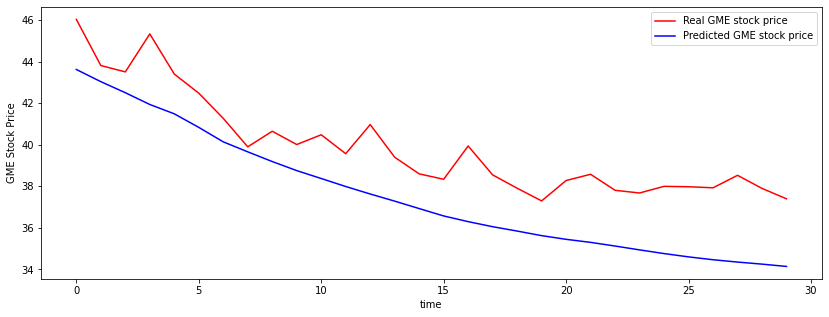

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(y_test, c='r', label='Real ' + ticker + ' stock price')
plt.plot(predictions, c='b', label='Predicted ' + ticker + ' stock price')
plt.xlabel('time')
plt.ylabel(ticker + ' Stock Price')
plt.legend()
plt.show()

In [ ]:
model.save('models/' + ticker)

INFO:tensorflow:Assets written to: models/GME/assets


In [ ]:
def update_data(ticker, api_key):
    f = open('ticker_folder/' + ticker + '.csv','a')
    with RESTClient(api_key) as client:
        resp = client.stocks_equities_aggregates(ticker=ticker, multiplier=10, timespan='minute',
                                                 from_='2021-02-04', to='2021-02-04', unadjusted=False,
                                                 sort='asc', limit=50000)
        resp = resp.results
        for query in resp:
            f.write(str(query['t']) + ',' + str(query['o']) + ',' + str(query['l']) + ','
                    + str(query['h']) + ',' + str(query['v']) + ',' + str(query['c']) + '\n')
    f.close()
    f = open('ticker_folder/' + ticker + '.csv', 'r')
    df = pd.read_csv(f)
    return df

In [ ]:
df2 = update_data(ticker, API_KEY)
df2.tail()

,timestamp,open,low,high,volume,close
3191,1612483800000,50.18,50.13,50.94,33918.0,50.13
3192,1612484400000,50.13,49.56,50.75,56667.0,50.51
3193,1612485000000,50.73,50.10,50.73,32266.0,50.10
3194,1612485600000,50.10,49.50,50.10,56866.0,49.60
3195,1612486200000,49.60,49.00,49.69,123666.0,49.17


In [ ]:
df2 = df2.drop(["timestamp"], axis=1)
df2.tail()

,open,low,high,volume,close
3191,50.18,50.13,50.94,33918.0,50.13
3192,50.13,49.56,50.75,56667.0,50.51
3193,50.73,50.10,50.73,32266.0,50.10
3194,50.10,49.50,50.10,56866.0,49.60
3195,49.60,49.00,49.69,123666.0,49.17


In [ ]:
model = keras.models.load_model('models/' + ticker)
x_train, y_train, x_test, y_test, scaler = split_data(df2)
predictions = model.predict(x_test)

In [ ]:
scale = 1 / scaler
predictions = predictions * scale
y_test = y_test * scale

plt.figure(figsize=(14, 5))
plt.plot(y_test, c='r', label='Real ' + ticker + ' stock price')
plt.plot(predictions, c='b', label='Predicted ' + ticker + ' stock price')
plt.xlabel('time')
plt.ylabel(ticker + ' Stock Price')
plt.legend()
plt.show()

In [ ]:
x_train, y_train, x_test, y_test, scaler = split_data(df2)


In [ ]:
def get_minute_data(ticker, api_key, last_minutes):  # gets minute by minute data for last (last_minutes) minutes
    f = open('recent_ticker_data/' + ticker + '.csv', 'w')
    with RESTClient(api_key) as client:
        resp = client.stocks_equities_aggregates(ticker=ticker, multiplier=1, timespan='minute',
                                                 from_='1999-07-12', to='2021-02-04', unadjusted=False,
                                                 sort='desc', limit=last_minutes)
        resp = resp.results
        f.write('timestamp,open,low,high,volume,close\n')
        for query in resp:
            f.write(str(query['t']) + ',' + str(query['o']) + ',' + str(query['l']) + ',' + str(query['h']) + ',' + str(query['v']) + ',' + str(query['c']) + '\n')
        f.close()
    f = open('recent_ticker_data/' + ticker + '.csv', 'r')
    df = pd.read_csv(f)
    return df

In [ ]:
df = get_minute_data('GME', API_KEY, 60)
df.head()

,timestamp,open,low,high,volume,close
0,1612486740000,49.00,49.00,49.48,29415,49.17
1,1612486680000,49.02,49.00,49.10,22745,49.01
2,1612486620000,49.25,49.01,49.25,21123,49.02
3,1612486560000,49.40,49.20,49.40,13707,49.20
4,1612486500000,49.41,49.40,49.56,10718,49.41


In [ ]:
def get_all_news(ticker, api_key):  # function works on pycharm, however google colab cannot open the csv file
    f = open(ticker + '_news.csv', 'w')
    f.write('date,title\n')
    with RESTClient(api_key) as client:
        for j in range(25):
            resp = client.reference_ticker_news(symbol=ticker, perpage=50, page=j)
            for i in range(50):
                f.write(resp.news[i].timestamp + ',' + resp.news[i].title + '\n')
    f.close()

In [ ]:
def get_polarity(headline):
    analysis = TextBlob(headline)
    return analysis.polarity

In [ ]:
polarity = get_polarity('GME is a good stock to buy')
print('polarity: ' + str(polarity))

polarity: 0.7
